In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
from captum.attr import LayerGradCam

class CustomCNN(nn.Module):
    def __init__(self, channels=8, fc_channels=8, kernel_size=3):
        super(CustomCNN, self).__init__()
       
        # First block
        self.conv1 = nn.Conv2d(1, channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
       
        # Second block
        self.conv2 = nn.Conv2d(channels, 2 * channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(2 * channels)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
       
        # Third block
        self.conv3 = nn.Conv2d(2*channels, 4 * channels, kernel_size, padding=kernel_size//2, dilation=2)
        self.bn3 = nn.BatchNorm2d(4 * channels)
        self.relu3 = nn.ReLU()
        #self.pool3 = nn.MaxPool2d(2)
       
        # Fourth block (no pooling after this)
        self.conv4 = nn.Conv2d(4*channels, 8 * channels, kernel_size, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(8 * channels)
        self.relu4 = nn.ReLU()
       
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(8*channels, fc_channels)
        self.relu_fc = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc_channels, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
       
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.drop1(self.relu_fc(self.fc1(x)))
        x = self.fc2(x)
       
        return x

def transform(img):
    '''Transform image to float in the [0,1] range and with 1 channel.'''
    img_t = torch.from_numpy(np.array(img)).contiguous()
    img_t = img_t.float()/255
    return img_t[None]

ds = MNIST('./data', train=True, download=False, transform=transform)

# This model has 98% accuracy on MNIST
model = CustomCNN()
model.load_state_dict(torch.load('./Models/mnist_model.pth'))

<All keys matched successfully>

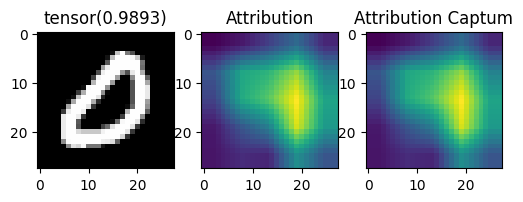

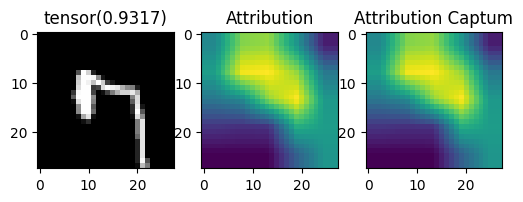

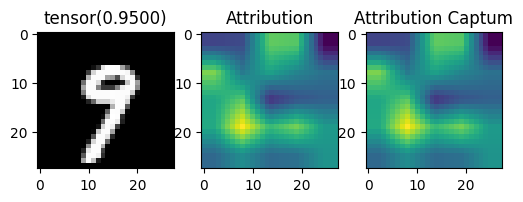

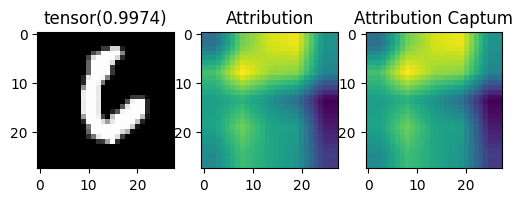

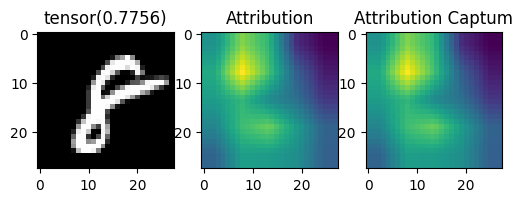

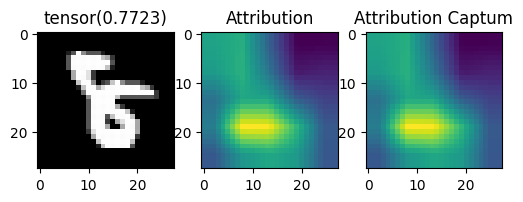

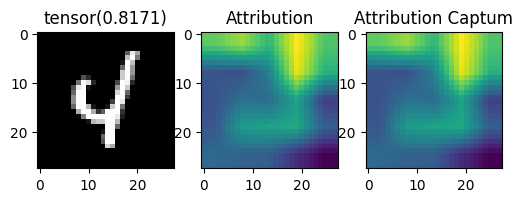

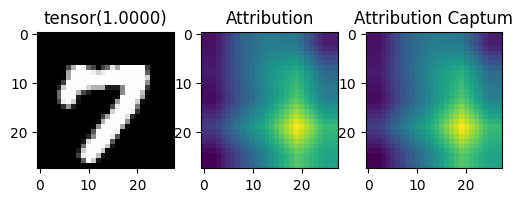

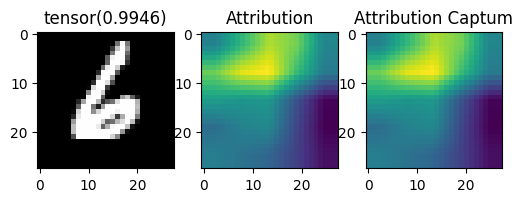

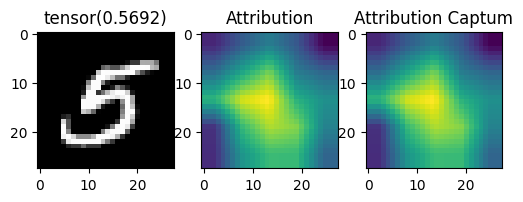

In [4]:
def create_hook():
    storage = {'act':None}
    def hook(module, args, output):
        storage['act'] = output
    return hook, storage

def grad_cam(model, img, label):

    model.eval()
    model.cpu()

    hook, storage = create_hook()
    handler = model.relu4.register_forward_hook(hook)
    # Apply model to image
    y = model(img[None])[0]
    # Get layer activation
    A = storage['act']
    # Get class score
    y_c = y[label]
    # Calculate gradient of y_c with respect to A
    y_c.backward(inputs=A)
    # Get the gradient. A and A.grad have dimension (1,64,7,7)
    # We clone the tensor to make sure that it will not be erased
    dydA = A.grad[0].clone()
    # Detach A from the computational graph 
    A = A[0].detach()
    # Calculate the average over spatial dimensions. alpha has shape (64,1,1)
    alpha = dydA.mean(dim=(1, 2), keepdim=True)
    # Sum the activations weighted by alpha
    L = F.relu((alpha*A).sum(dim=0))
    # Interpolate the result to the same shape as the image
    atribution = F.interpolate(L.reshape(1,1,*L.shape), size=img.shape[-2:], mode='bilinear')
    atribution = atribution.squeeze()
    # Get probabilities. 
    probs = F.softmax(y.detach(), dim=0)

    # Remove hook
    handler.remove()

    return atribution, probs, A, dydA

def grad_cam_cap(model, img, label):

    grad_cam_cap = LayerGradCam(model, model.relu4)
    L = grad_cam_cap.attribute(img[None], target=label, relu_attributions=True)
    L = L.detach()
    atribution = F.interpolate(L, size=img.shape[-2:], mode='bilinear')
    atribution = atribution.squeeze()

    return atribution

def attributions(model, ds, n):
    '''Randomly select `n` images to show attributions.'''

    indices = list(range(len(ds)))
    random.shuffle(indices)
    
    for idx in indices[:n]:
        img, label = ds[idx]
        atribution, probs, A, dydA = grad_cam(model, img, label)
        atribution_cap = grad_cam_cap(model, img, label)
        
        plt.figure(figsize=[6, 3])
        plt.subplot(1, 3, 1)
        plt.imshow(img[0], 'gray')
        plt.title(probs[label])
        plt.subplot(1, 3, 2)
        plt.imshow(atribution)
        plt.title('Attribution')
        plt.subplot(1, 3, 3)
        plt.imshow(atribution_cap)
        plt.title('Attribution Captum')

        # Check if the results are equal
        if not atribution.allclose(atribution_cap):
            print('Methods differ')

attributions(model, ds, 10)